# Project 2: Named Entity Recognition (NER) with Sequence Labeling Models


Altria Wang and Johann Lee

# **Introduction** 🔎

---

The given dataset is from CoNLL-2003 ([Sang et al](https://arxiv.org/pdf/cs/0306050v1.pdf)) dataset. We will develop a Hidden Markov Model (with Viterbi) and a Maximum Entropy Markov Model to identify these named entities automatically. We will treat this as a **sequence-tagging task**: for each token in the input text, assign one of the following 5 labels: **ORG** (Organization), **PER** (Person), **LOC** (Location), **MISC** (Miscellaneous), and **O** (Not Named Entity). 

# **Part 1: Dataset** 📈

Data from https://www.kaggle.com/c/cs4740-fa21-p2/

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import json
import numpy as np

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(), "drive", "MyDrive", "nlp_proj2")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())



In [ ]:
import json
import numpy as np
with open('train.json', 'r') as f:
     train = json.loads(f.read())

with open('test.json', 'r') as f:
     test = json.loads(f.read())

The following 4 fields are (each is a nested list): 
  - **'text'** - actual input tokens
  - **'NER'** - the token-level entity tag (ORG/PER/LOC/MISC/O) where **O is used to denote tokens that are not part of any named entity**
  - **'POS'** - the part of speech tag (will be handy for feature engineering of the MEMM model)
  - **'index'** - index of the token in the dataset

Let's take a look at a sample sentence from the dataset!

In [ ]:
print(train['text'][15])
print(train['index'][15])
print(train['POS'][15])
print(train['NER'][15])

### **Q1: Initial Data Observations**

In [ ]:
import pandas as pd
import numpy as np
df_describe = pd.DataFrame(len(n) for n in train['text'])
df_describe.describe()

,0
count,756.000000
mean,214.736772
std,164.921786
min,24.000000
25%,101.000000
50%,177.000000
75%,263.000000
max,1335.000000


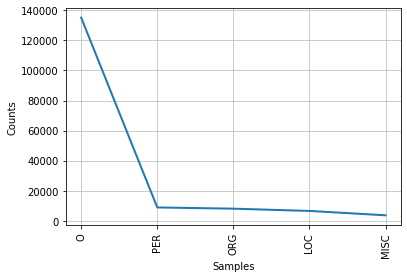

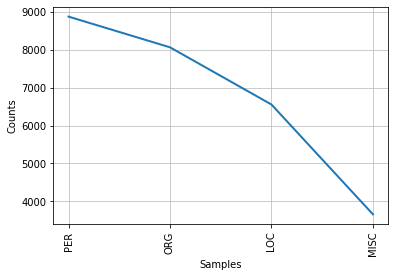

In [ ]:
from nltk import *
def append_lst(data):
  appended_list = []
  for document in data:
   for items in document:
     appended_list.append(items)
  return appended_list

def append_lst_no_o(data):
  appended_list_no_o = []
  for document in data:
   for items in document:
     if items != "O":
      appended_list_no_o.append(items)
  return appended_list_no_o


new_list = append_lst(train['NER'])
new_list_no_o = append_lst_no_o(train['NER'])
freq_list_word = FreqDist(new_list)
freq_list_no_o = FreqDist(new_list_no_o)
freq_list_word.plot(5)
freq_list_no_o.plot(10)

# **Part 2: Hidden Markov Model** 

## **Unknown Word Handling**
---

In [ ]:
# # Implement unknown word handling here! You may do this any way that you please
def handle_unknown(tokens):
  tokens_handled = tokens
  seen_tokens = []
  for i, token_set in enumerate(tokens):
    for j, token in enumerate(token_set):
      if token not in seen_tokens:
        seen_tokens.append(token)
        tokens_handled[i][j] = '<unk>'
        # print('working')

  return tokens_handled

In [ ]:
print(handle_unknown([['Cornell',
 'University',
 'is',
 'located',
 'in',
 'Ithaca',
 'by',
 'Ezra',
 'Cornell']]))

[['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'Cornell']]


## **HMM Implementation**

---

We have broken down the HMM into its three components: the transition matrix, the emission (i.e., lexical generation, observation) matrix, and the starting state probabilities.

In [ ]:
def find_unique(dataset, has_s):
  unique_set = []
  if has_s: unique_set.append("<s>")
  for cur_set in dataset: 
    for element in cur_set:
      if element not in unique_set:
        unique_set.append(element)
  return unique_set

In [ ]:
# states are NER categories
# transition probs are bigram probs
# observation probs: p(word | category)

In [ ]:
# transition probability P(ti|ti-1)
def trans(labels, unique_labels, k):
  # initialize
  count_pairs = {} # count(ti-1, ti)
  count_labels = {} # count(ti-1)
  for label1 in unique_labels:
    count_labels[label1] = k
    count_pairs[label1] = {}
    for label2 in unique_labels:
      count_pairs[label1][label2] = k

  # get counts
  for label_set in labels:
    is_first = True
    for i in range(len(label_set)):
      # set cur & prev
      cur_label = label_set[i]
      if is_first: 
        is_first = False
        prev_label = "<s>"
        count_labels["<s>"] += 1
      else:
        prev_label = label_set[i-1]
      
      # increment counts
      count_pairs[prev_label][cur_label] += 1
      count_labels[cur_label] += 1

  # get prob P(ti|ti-1) = count(ti-1, ti) / count(ti-1)
  tran_probs = {}
  size = len(unique_labels)
  for label1 in unique_labels:
    tran_probs[label1] = {}
    for label2 in unique_labels:
      tran_probs[label1][label2] = count_pairs[label1][label2] / (count_labels[label1]+k*size)
  
  return tran_probs

# emission probability P(wi|ti)
def emi(tokens, labels, unique_tokens, unique_labels, k):
  # initialize
  count_pairs = {} # count(ti, wi)
  count_labels = {} # count(ti)
  for label in unique_labels:
    count_pairs[label] = {}
    count_labels[label] = k
    for token in unique_tokens:
      count_pairs[label][token] = 0 # k

  # get counts
  for token_set, label_set in zip(tokens, labels):
    for token, label in zip(token_set, label_set):
      count_pairs[label][token] += 1
      count_labels[label] += 1
  
  # get prob P(wi|ti) = count(ti, wi) / count(ti)
  emi_probs = {}
  size = len(unique_tokens)
  # size = len(unique_labels)
  for label in unique_labels:
    emi_probs[label] = {}
    for token in unique_tokens:
      emi_probs[label][token] = count_pairs[label][token] / (count_labels[label]+k*size)
  
  return emi_probs

# start state probability P(ti|<s>)
def start(labels, unique_labels, k):
  # initialize
  start_probs = {} # count(ti|<s>)
  s_count = 0 # count(<s>)
  for label in unique_labels:
    start_probs[label] = k
  
  # get counts
  for label_set in labels:
    for label in label_set:
      start_probs[label] += 1
      s_count += 1
      break
  
  # get probs P(ti|<s>) = count(ti|<s>) / count(<s>)
  size = len(unique_labels)
  for label in unique_labels:
    start_probs[label] /= (s_count+k*size)
  
  return start_probs

In [ ]:
import copy
def build_hmm_new(tokenss, labels, k, has_handle_unknown):
  hmm = {}
  tokens = copy.deepcopy(tokenss) # so we get a new one and not a pointer
  if has_handle_unknown: tokens = handle_unknown(tokens)
  unique_labels = find_unique(labels, True) # labels need <s>
  unique_tokens = find_unique(tokens, False) # tokens start at 1st word and don't need <s>

  hmm['transition'] = trans(labels, unique_labels, k)
  hmm['emission'] = emi(tokens, labels, unique_tokens, unique_labels, k)
  hmm['start_state'] = start(labels, unique_labels, k)
  return hmm



## **Viterbi Implementation**

---

Maps a sequence of tokens (observation) to a sequence of labels via the Viterbi algorithm.

In [ ]:
def give_max(tag_i, t, c, scores, hmm, true_tags, word_t):
  max_score = 0
  index = 0
  for j in range(c):
    tag_j = true_tags[j]
    cur_score = scores[j, t-1]*hmm['transition'][tag_j][tag_i] * hmm['emission'][tag_i][word_t]
    if max_score < cur_score: 
      max_score = cur_score
      index = j
  return max_score, index

In [ ]:
# takes in the hmm build above and an observation: list of tokens
# and returns the appropriate named entity mappings for the tokens
def viterbi(hmm, obs):
  
  # setup
  true_tags = list(hmm['transition'])
  if "<s>" in true_tags: true_tags.remove('<s>')   # ignore '<s>' and '<unk>'
  if "<unk>" in true_tags: true_tags.remove('<unk>')
  c = len(true_tags)
  n = len(obs)
  scores = np.zeros(shape=(c,n))
  backpointer = np.zeros(shape=(c,n))

  # initialization
  for i in range(c): 
    tag_i = true_tags[i] 
    if obs[0] in hmm['emission'][tag_i].keys():
      scores[i,0] = hmm['transition']['<s>'][tag_i] * hmm['emission'][tag_i][obs[0]]
    else: 
      scores[i,0] = hmm['transition']['<s>'][tag_i] * hmm['emission'][tag_i]['<unk>']
    backpointer[i,0] = 0 

  # iteration
  for t in range(1,n): 
    for i in range(c): 
      tag_i = true_tags[i]
      if tag_i == '<s>' or tag_i == '<unk>': continue # skip <s> & <unk>
      if obs[t] in hmm['emission'][tag_i].keys():
        scores[i,t], max_index = give_max(tag_i, t, c, scores, hmm, true_tags, obs[t])
      else:
        scores[i,t], max_index = give_max(tag_i, t, c, scores, hmm, true_tags, '<unk>')
      backpointer[i,t] = max_index
  # print(scores)
  
  #identify sequence
  sequence_index = []
  max_score = 0
  max_score_index = 0
  for j in range(c): 
    if max_score < scores[j,n-1]:
      max_score = scores[j,n-1]
      max_score_index = j
  sequence_index.append(max_score_index) # T(n) on slide 27

  for i in range(n-2, -1, -1): # on slide: for i = n-1 to 1 do
    sequence_index.insert(0, int(backpointer[sequence_index[0], i+1])) # T(i) = BPTR(T(i+1), i+1)

  sequence = []
  for ind in sequence_index:
    sequence.append(true_tags[ind])  # turning indices back to tags
  return sequence

## **Validation**

---


In [ ]:
from sklearn.model_selection import train_test_split
training_set_text, validation_set_text = train_test_split(train['text'], test_size = 189,train_size = 567, random_state = False)
training_set_ner, validation_set_ner  = train_test_split(train['NER'], test_size = 189,train_size = 567, random_state = False)
training_set_pos, validation_set_pos = train_test_split(train['POS'], test_size = 189,train_size = 567, random_state = False)
training_set_index, validation_set_index= train_test_split(train['index'],test_size = 189,train_size = 567, random_state = False)
validation_dataset = validation_set_text + validation_set_ner + validation_set_pos + validation_set_index

In [ ]:
my_hmm = build_hmm_new(training_set_text, training_set_ner, 0.001, True)

In [ ]:
# here's a samplle observations that you can use to test your code
obs_1 = ['Cornell',
 'University',
 'is',
 'located',
 'in',
 'Ithaca',
 'and',
 'was',
 'founded',
 'by',
 'Ezra',
 'Cornell']

viterbi(obs=obs_1, hmm=my_hmm)

['ORG', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

After getting a sequence of NER labels for the sequence of tokens from our Viterbi algorithm implementation, we need to convert the sequence of tokens, associated token indices and NER labels into a format which can be used to calculate **Entity Level Mean F1**. 

We do this by finding the starting and ending indices of the spans representing each entity (as given in the corpus) and adding it to a list that is associated with the label with which the spans are labelled. To score our validation data, we can get a dictionary format from the function **format_output_labels** of both the predicted and true label sequences, and use the two dictionaries as input to the **mean_f1** function.

NOTE: We do **not** include the spans of the tokens labelled as "O" in the formatted dictionary output.

In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (LOC, ORG, MISC or PER) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    Eg. if [token_labels] = ["ORG", "ORG", "O", "O", "ORG"]
           [token_indices] = [15, 16, 17, 18, 19]
        then dictionary returned is 
        {'LOC': [], 'MISC': [], 'ORG': [(15, 16), (19, 19)], 'PER': []}

    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"LOC":[], "MISC":[], "ORG":[], "PER":[]}
    prev_label = token_labels[0]
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      if prev_label != label:
        # print(len(token_indices), idx)
        end = token_indices[idx-1]
        if prev_label != "O":
            # print(prev_label) # added in, delete later
            label_dict[prev_label].append((start, end))
        start = token_indices[idx]
      prev_label = label
      if idx == len(token_labels) - 1:
        if prev_label != "O":
            label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict

In [ ]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    """ 
    Calculates the entity-level mean F1 score given the actual/true and 
    predicted span labels.
    :parameter y_pred_dict: A dictionary containing predicted labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_pred_dict: Dict<key [String] : value List[Tuple]>
    :parameter y_true_dict: A dictionary containing true labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_true_dict: Dict<key [String] : value List[Tuple]>

    Implementation modified from original by author @shonenkov at
    https://www.kaggle.com/shonenkov/competition-metrics.
    """
    
    F1_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        F1_lst.append(F1)
    return np.mean(F1_lst)

In [ ]:
# Evaluate/validate your model here
def find_f1(validation_set_text, validation_set_ner, validation_set_index, hmm):
  count = 0
  meanf1 = 0
  for cur_text, cur_ner, cur_indices in zip(validation_set_text, validation_set_ner, validation_set_index):
    cur_pred = viterbi(obs = cur_text, hmm = hmm)
    
    # print('pred', len(cur_pred), 'ner', len(cur_ner), 'indices', len(cur_indices), 'text',len(cur_text))
    y_true_dict = format_output_labels(cur_ner, cur_indices)
    y_pred_dict = format_output_labels(cur_pred, cur_indices)

    meanf1 += mean_f1(y_pred_dict, y_true_dict)
    count += 1
  meanf1 /= count
  return meanf1

In [ ]:
find_f1(validation_set_text,validation_set_ner,validation_set_index,my_hmm)

0.4540337100708901

In [ ]:
# Code for mean F1

import numpy as np

def mean_f1PR(y_pred_dict, y_true_dict):
  
    F1_lst = []
    P_lst = []
    R_lst = []
    A_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
                R = 0
                P = 0
        else:
            continue
        F1_lst.append(F1)
        P_lst.append(P)
        R_lst.append(R)
    return np.mean(P_lst), np.mean(R_lst), np.mean(F1_lst)

In [ ]:
# Evaluate/validate your model here
def find_f1PR(cur_hmm):
  count = 0
  mean_acc = 0
  meanf1 = 0
  mean_pre = 0
  mean_rec = 0
  for cur_text, cur_ner, cur_indices in zip(validation_set_text, validation_set_ner, validation_set_index):
    wrong = 0
    # if count > 1: break
    cur_pred = viterbi(obs = cur_text, hmm = cur_hmm)
    
    for ner, pred in zip(cur_ner, cur_pred):
      if ner != pred: wrong +=1
    mean_acc += 1-wrong/len(cur_ner)
    y_true_dict = format_output_labels(cur_ner, cur_indices)
    y_pred_dict = format_output_labels(cur_pred, cur_indices)

    cur_pre, cur_rec, cur_f1 = mean_f1PR(y_pred_dict, y_true_dict)
    
    mean_pre += cur_pre
    mean_rec += cur_rec
    meanf1 += cur_f1
    count += 1
  meanf1 /= count
  print("mean_acc", mean_acc/count)
  print("mean_pre", mean_pre/count)
  print("mean_rec", mean_rec/count)
  return meanf1

In [ ]:
find_f1PR(my_hmm)

mean_acc 0.8901056645626279
mean_pre 0.6286847942866465
mean_rec 0.41082728151990844


0.4540337100708901

In [ ]:
# finding the best smoothing k
f1s = []
for i in np.arange(0.0001, 0.01, 0.0005):
  my_hmms = build_hmm_new(training_set_text, training_set_ner, i, True)
  cur_f1 = find_f1(validation_set_text, validation_set_ner, validation_set_index, my_hmms)
  # print(i, cur_f1)
  f1s.append((i, cur_f1))
f1s

# **Part 3: Maximum Entropy Markov Model** 

---

We use the classifier to learn a probability $P(t_i|features)$. We replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it then apply the **Viterbi algorithm**. 

### **Feature Engineering**
---

In [ ]:
# Get the feature: previous label
start_ner = '<start>'
def prev_ner (ner):
  prev_ner = []
  prev_ner.append(start_ner)
  for item in ner:
    prev_ner.append(item)
  return (prev_ner[0:-1])

In [ ]:
def change(text, ner, prev,pos):
  our_feature = []
  for doc, doc_ner, prevs,tags in zip(text, ner, prev,pos):
    # doc_prev = prev_ner(doc_ner)
    for word, ner, prev, tag in zip(doc, doc_ner, prevs, tags):
      item = word, ner, prev, tag 
      our_feature.append(item)
  return our_feature

In [ ]:
training_set_ner[0][:5]

['O', 'O', 'PER', 'PER', 'O']

In [ ]:
import copy
training_set_prev_ner = copy.deepcopy(training_set_ner)
for doc in training_set_prev_ner:
  doc.insert(0, '<s>')
  doc = doc[:-1]

In [ ]:
list_for_corp = ["ltd.", "ltd", "associates", "inc.", "Inc","inc", "co.", "co", "corp.", "corp", "University", "Bank", "Commission", "Institute", "Airlines"]

In [ ]:
def if_comp(word, list):
  if word in list:
    return True
  else:
    return False

In [ ]:
if_comp("inc", list_for_corp)

True

In [ ]:
def get_features(word, previous_ner, tag, isUpper, isUpperAll):
	features = {} 
	features['current_word'] = word
	features['previous_ner'] = previous_ner
	features['current_tag'] = tag
	features['first_capitalization'] = isUpper #word[0].isupper()
	features['all_capitalization'] = isUpperAll
	features["Corporate-Suffix"] = if_comp(word, list_for_corp)

	return features

featureset_correct_format = [(get_features(word, previous_ner, tag, word[0].isupper(), word.isupper()), ner) for (word, ner, previous_ner, tag) in change(training_set_text, training_set_ner, training_set_prev_ner, training_set_pos)]
# featureset_correct_format = [(get_features(word, previous_ner, tag), ner) for (word, ner, previous_ner, tag) in (change(training_set_text, training_set_ner, training_set_pos))]
# training_feature = labeled_featuresets
training_feature = featureset_correct_format

In [ ]:
training_feature[0]

({'Corporate-Suffix': False,
  'all_capitalization': True,
  'current_tag': 'NNP',
  'current_word': 'ATHLETICS',
  'first_capitalization': True,
  'previous_ner': '<s>'},
 'O')

### **MEMM Implementation**
---

In [ ]:
def flatten_list(input):
  flat_list = []
  for text in input:
    for item in text:
      flat_list.append(item)
  return flat_list

In [ ]:
def unique(list):
    x = np.array(list)
    return (np.unique(x)).tolist()

unique(flatten_list(training_set_ner))

['LOC', 'MISC', 'O', 'ORG', 'PER']

In [ ]:
import nltk
from nltk import *
from nltk.classify import MaxentClassifier
import pickle

f = open("my_classifier.pickle", "wb")

maxent = MaxentClassifier.train(training_feature, max_iter=30)

pickle.dump(maxent, f)

f.close()

  ==> Training (30 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.60944        0.056
             2          -0.20997        0.832
             3          -0.16674        0.910
             4          -0.14154        0.964
             5          -0.12597        0.969
             6          -0.11512        0.976
             7          -0.10686        0.977
             8          -0.10018        0.979
             9          -0.09457        0.981
            10          -0.08974        0.982
            11          -0.08550        0.983
            12          -0.08173        0.984
            13          -0.07834        0.986
            14          -0.07528        0.986
            15          -0.07250        0.987
            16          -0.06996        0.987
            17          -0.06762        0.988
            18          -0.06547        0.988
            19          -0.06348        0.988
  

In [ ]:
# to use next time so we don't have to re-train
f = open('my_classifier.pickle', 'rb')
maxent = pickle.load(f)
f.close()

In [ ]:
# takes in the hmm build above and an observation: list of tokens
# and returns the appropriate named entity mappings for the tokens
def viterbi_mmem(mmem, text, pos):
  
  # setup
  true_tags = ["LOC", "MISC", "ORG", "PER", "O"]
  # if "<s>" in true_tags: true_tags.remove('<s>')
  # if "<unk>" in true_tags: true_tags.remove('<unk>')  # ignore '<s>' and '<unk>'
  c = len(true_tags)
  n = len(text)
  scores = np.zeros(shape=(c,n))
  backpointer = np.zeros(shape=(c,n))

  # initialization
  for i in range(c):
    tag_i = true_tags[i]
    prev_ner = "<s>"
    cur_word = text[0]
    cur_tag = pos[0]
    cur_features = get_features(cur_word, prev_ner, cur_tag, cur_word[0].isupper(), cur_word.isupper())
    prob_dist = mmem.prob_classify(cur_features)
    scores[i,0] = float(prob_dist.prob(tag_i))
    backpointer[i,0] = 0

  # iteration
  for t in range(1,n): 
    predictions = {} # for word
    for i in range(c): 
      cur_word = text[t]
      cur_tag = pos[t]
      prev_ner = true_tags[i] # loop through all possible previous ners
      cur_features = get_features(cur_word, prev_ner, cur_tag, cur_word[0].isupper(), cur_word.isupper())
      prob_dist = mmem.prob_classify(cur_features) # given left word and its features, prob of right words
     
     # predictions maps right ner -> [prob of each left ner]
      for tag in true_tags:
        if tag in predictions: predictions[tag].append(prob_dist.prob(tag))
        else: predictions[tag] = [prob_dist.prob(tag)]

    for i in range(c):
      max_score = 0
      max_score_ner = 0
      tag_i = true_tags[i]
      for j in range(c):
        tag_j = true_tags[j]
        cur_score = scores[j, t-1]*predictions[tag_i][j] # for 1 right which ith left is largest left
        if max_score < cur_score: 
          max_score = cur_score
          max_score_ner = j
      scores[i,t] = max_score
      backpointer[i,t] = max_score_ner
  
  #identify sequence, the rest is the same as the viterbi above
  sequence_index = []
  max_score = 0
  max_score_index = 0
  for j in range(c): 
    if max_score < scores[j,n-1]:
      max_score = scores[j,n-1]
      max_score_index = j
  sequence_index.append(max_score_index) # T(n) on slide 27

  for i in range(n-2, -1, -1): # for i = n-1 to 1 do
    sequence_index.insert(0, int(backpointer[sequence_index[0], i+1])) # T(i) = BPTR(T(i+1), i+1)

  sequence = []
  for ind in sequence_index:
    sequence.append(true_tags[ind])  
  return sequence

### **Validation**
---


In [ ]:
# Evaluate/validate your model here
def find_f1_mmem(validation_set_text, validation_set_pos, validation_set_ner, validation_set_index, mmem):
  count = 0
  meanf1 = 0
  for cur_text, cur_pos, cur_ner, cur_indices in zip(validation_set_text, validation_set_pos, validation_set_ner, validation_set_index):
    cur_pred = viterbi_mmem(mmem = mmem, text = cur_text, pos = cur_pos)
    
    y_true_dict = format_output_labels(cur_ner, cur_indices)
    y_pred_dict = format_output_labels(cur_pred, cur_indices)

    meanf1 += mean_f1(y_pred_dict, y_true_dict)
    count += 1
    if count>=0:break
  meanf1 /= count
  return meanf1


In [ ]:
find_f1_mmem(validation_set_text, validation_set_pos, validation_set_ner, validation_set_index, maxent)

0.9097222222222222

# **Part 5: Kaggle Submission**
---

In [ ]:
# MEMM
list_for_pred = []
list_for_index = []
for cur_text, cur_pos, cur_indices in zip(test['text'], test['POS'], test['index']):
  cur_pred = viterbi_mmem(mmem=maxent, text=cur_text, pos=cur_pos)
  # for items in cur_pred:
  #   if items != 'O':
  list_for_pred.append(cur_pred)
  list_for_index.append(cur_indices)
# print(list_for_pred[0])
# list_for_index[0]

In [ ]:
# HMM

hmm_list_for_pred = []
hmm_list_for_index = []
for cur_text, cur_indices in zip(test['text'], test['index']):
  cur_pred = viterbi(hmm=my_hmm, obs=cur_text)
  hmm_list_for_pred.append(cur_pred)
  hmm_list_for_index.append(cur_indices)

In [ ]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Expected']

        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Expected': p_string})

In [ ]:
flat_pred=flatten_list(list_for_pred)
flat_index=flatten_list(list_for_index)

In [ ]:
create_submission("memm.csv", flat_pred, flat_index) #memm

In [ ]:
create_submission("hmm.csv", flatten_list(hmm_list_for_pred), flatten_list(hmm_list_for_index))